In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import math
import time
from heateq import Exact, Simulateur

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
def rmse_estim(estimations, statistique_exacte):
    return math.sqrt(np.mean((estimations - statistique_exacte)**2))

In [5]:
def plot_fig_cv(budgets, esp_mean_mc, std_mean_mc, rmse_mean_mc,  esp_mean_cv, std_mean_cv, rmse_mean_cv, mu_exact):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    eb_mc = axs[0].errorbar(
        budgets, esp_mean_mc, std_mean_mc,
        fmt='x', color='gray', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Monte Carlo'
    )
    eb_cv = axs[0].errorbar(
        budgets, esp_mean_cv, std_mean_cv,
        fmt='xb', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Control variate'
    )
    hl = axs[0].axhline(y=mu_exact, linestyle="--", dashes=(3, 3), linewidth=1, color="red", dash_capstyle="round")
    axs[0].set_xscale('log')
    axs[0].set_xlabel('budget')
    axs[0].set_ylabel("estimation de l'espérance")

    axs[1].plot(budgets, rmse_mean_mc, 'o-', color='gray', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo HF')
    axs[1].plot(budgets, rmse_mean_cv, 'ob-', lw=3, markeredgewidth=2, markersize=6, label='Control variate')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('budget')
    axs[1].set_ylabel('REQM des estimateurs')
    axs[1].legend()

In [6]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 60)
g = Simulateur(3, 15)

In [7]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.79240142364666
32.93997614914162


In [8]:
ns = 100000
X = n_echantillon_X(ns)

st = time.process_time()
Y = f(X)
et = time.process_time()
time_hf = et - st

st = time.process_time()
Z = g(X)
et = time.process_time()
time_bf = et - st

w = time_bf / time_hf

# rapport de coût (temps)
print(w)

0.04048856828504704


In [9]:
# On considère désormais le rapport w=1/35 théorique
w = 1/28
print(w)

0.03571428571428571


# Expérience pilote

In [10]:
cov_matrix_YZ = np.cov(Y, Z)
cov_YZ = cov_matrix_YZ[0,1]
var_Y = cov_matrix_YZ[0,0]
var_Z = cov_matrix_YZ[1,1]

In [11]:
rho2 = cov_YZ**2 / (var_Y * var_Z)
print(rho2)

0.9819433558778363


In [12]:
# Rapport de variance ACV/MC à coût équivalent
beta_mu_Z_inconnue = ( 1 + math.sqrt( w * rho2/(1-rho2) ) )**2 * (1 - rho2)
print(beta_mu_Z_inconnue)

0.10345440256910521


In [13]:
# Pour ACV
tau_opt = math.sqrt( rho2 / (w*(1-rho2)) )
print(tau_opt)

39.02147794192851


In [14]:
alpha_opt = (1 - 1/tau_opt) * cov_YZ / var_Z
print(alpha_opt)

0.9798998731909442


In [15]:
# Nombre de répétitions et liste de budgets
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

# Estimateur multifidélité

In [16]:
# mu_Z inconnue, alpha indep
esp_Y_cv_mean = []
std_Y_cv_mean = []
rmse_Y_cv_mean = []
esp_Y_mean = []
std_Y_mean = []
rmse_Y_mean = []

for n_tilde in budgets:
    Y_cv_mean = np.zeros(nr)
    Y_mean = np.zeros(nr)
    n_opt = n_tilde / (1 + w*tau_opt)
    N_opt = (tau_opt - 1) * n_opt
    n_opt = int( math.floor(n_opt) )
    N_opt = int( math.floor(N_opt) )
    for ir in range(nr):
        X_n = n_echantillon_X(n_opt)
        X_N = n_echantillon_X(N_opt)
        X_n_tilde = n_echantillon_X(n_tilde)
        
        Y_n = f(X_n)
        Y_n_tilde = f(X_n_tilde)
        
        Z_n = g(X_n)
        Z_N = g(X_N)
        
        Y_mean_n_tilde = np.mean(Y_n_tilde)
        Y_mean_n = np.mean(Y_n)
        
        Z_mean_n = np.mean(Z_n)
        Z_mean_N = np.mean(Z_N) # estimation "precise" de l'esperance
        
        Y_mean[ir] = Y_mean_n_tilde
        Y_cv_mean[ir] = Y_mean_n - alpha_opt * (Z_mean_n - Z_mean_N)

    esp_Y_mean += [np.mean(Y_mean)]
    std_Y_mean += [np.std(Y_mean)]
    rmse_Y_mean += [rmse_estim(Y_mean, mu_exact)]
    
    esp_Y_cv_mean += [np.mean(Y_cv_mean)]
    std_Y_cv_mean += [np.std(Y_cv_mean)] 
    rmse_Y_cv_mean += [rmse_estim(Y_cv_mean, mu_exact)]
    
    print(n_tilde, n_opt, N_opt,
        esp_Y_cv_mean[-1], esp_Y_mean[-1], rmse_Y_cv_mean[-1], rmse_Y_mean[-1], (std_Y_cv_mean[-1] / std_Y_mean[-1])**2 
    )

5 2 79 42.6075612271474 42.5443428269927 15.137133302236712 47.77606593422426 0.10022813672275621
10 4 158 41.57162902656421 42.24352794276947 11.446733580751644 33.91134784327264 0.11379759876507482
20 8 317 41.61828946283377 42.1561001407287 7.578151573979829 22.959712058485255 0.10869329320985217
50 20 794 42.05805599670929 41.49578324986409 5.05085398860489 15.337277908807623 0.10853804747779895
100 41 1588 41.81842998001877 41.80055227055851 3.5020819419999207 11.595311035695202 0.09103737221223274
200 83 3176 41.623264310463625 41.83783943694042 2.4757568912309718 7.355775827223917 0.1109142490324021
500 208 7942 41.84428287842646 41.830147594906244 1.5258706457071616 4.818883208132413 0.09951919020840715
1000 417 15884 41.806968673970275 41.877335552423276 1.0830827853827625 3.389491730712415 0.09946356462686973
2000 835 31768 41.8008177572121 41.746597037653906 0.7776563732511009 2.408422034233345 0.09941316677687596
5000 2088 79422 41.777679721356336 41.688293259103084 0.52301

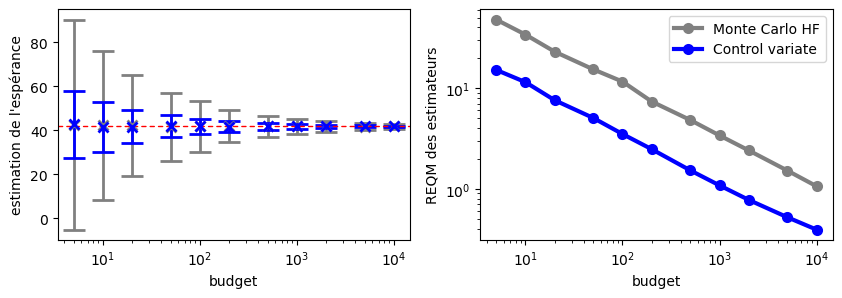

In [17]:
plot_fig_cv(budgets, esp_Y_mean, std_Y_mean, rmse_Y_mean, esp_Y_cv_mean, std_Y_cv_mean, rmse_Y_cv_mean, mu_exact)